In [131]:
import torch
from fastai.vision.all import *

# Make absolutely sure default device is CPU
torch.backends.mps.is_available = lambda : False
torch.backends.mps.is_built = lambda : False

path = Path('./animals_dataset/train')

# Rebuild DataLoaders on CPU
dls = ImageDataLoaders.from_folder(
    path,
    train='.',
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    bs=64
)

print(f"Number of classes: {len(dls.vocab)}")
print(f"Classes: {dls.vocab}")
print(f"Training samples: {len(dls.train_ds)}")
print(f"Validation samples: {len(dls.valid_ds)}")


Number of classes: 5
Classes: ['capybara', 'cat', 'dog', 'owl', 'rabbit']
Training samples: 509
Validation samples: 127


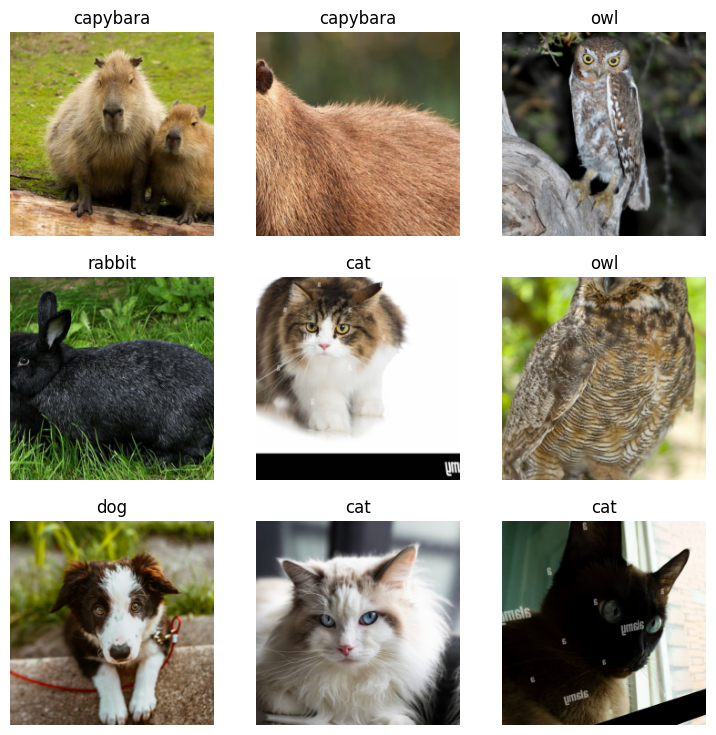

In [106]:
dls.show_batch(max_n=9)

In [107]:
dls = dls.cpu()  # force CPU dataloaders

# Build learner on CPU
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.model = learn.model.to("cpu")

SuggestedLRs(valley=0.0004786300996784121)

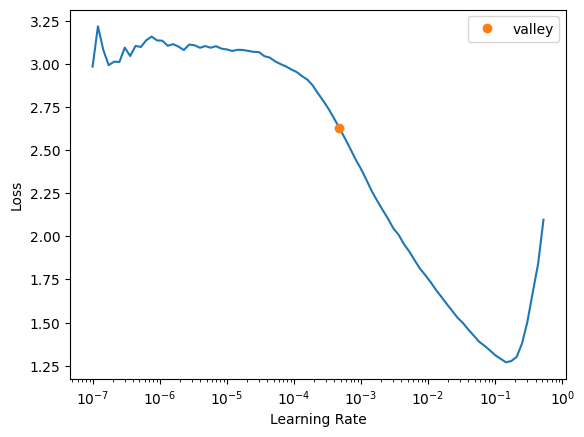

In [108]:
learn.lr_find()

In [ ]:
lr =  0.0007918309954926372
epochs =  5

In [110]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.014196,0.692387,0.181102,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.578964,0.245819,0.086614,00:45
1,0.417599,0.187205,0.062992,00:44


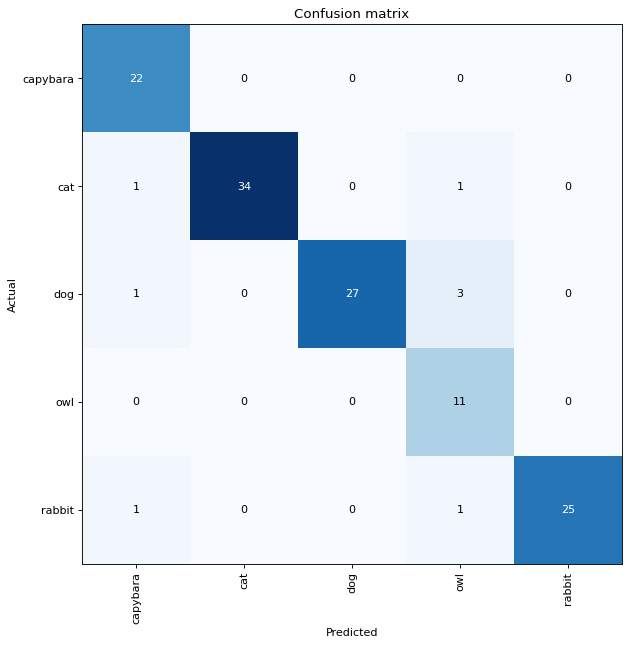

In [111]:
# Create interpretation object
interp = ClassificationInterpretation.from_learner(learn)

# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(8, 8), dpi=80)

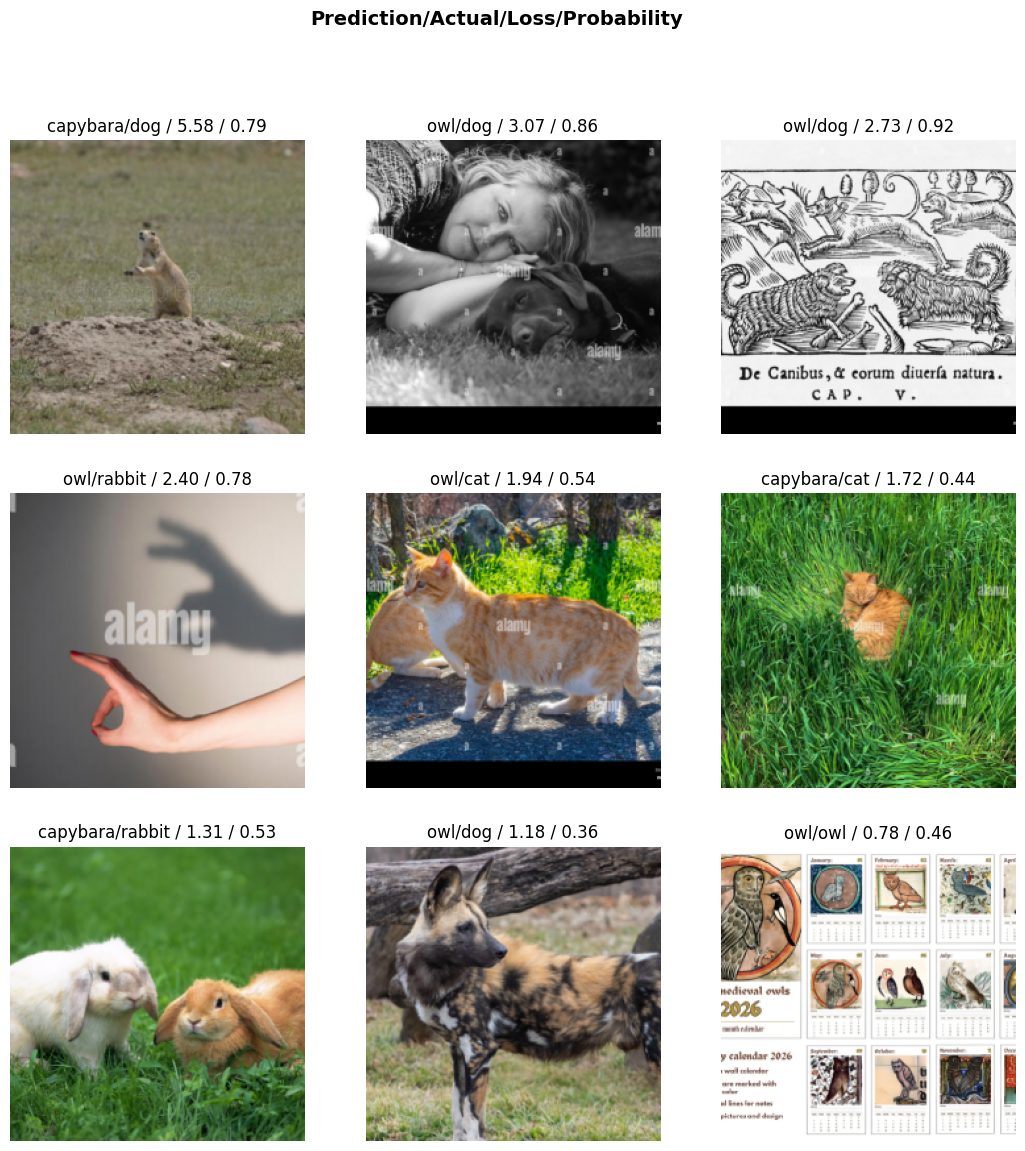

In [112]:
interp.plot_top_losses(9, figsize=(13, 13))

In [113]:
test_path = Path('./animals_dataset/test')
test_dl = learn.dls.test_dl(get_image_files(test_path))

print(f"Test set size: {len(test_dl.items)}")


Test set size: 215


In [121]:
# Create a test DataLoader
test_path = Path('./animals_dataset/test' )
test_dl = learn.dls.test_dl(get_image_files(test_path))
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]
# Calculate test accuracy
from statistics import mean

test_accuracy = mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)])
test_error_rate = 1 - test_accuracy

print(f"\nTEST RESULTS:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Error Rate: {test_error_rate:.4f} ({test_error_rate*100:.2f}%)")

# Per-class accuracy
print(f"\nPER-CLASS RESULTS:")
for class_name in class_names:
    class_true = [i for i, true_class in enumerate(true_class_names) if true_class == class_name]
    if len(class_true) > 0:
        class_correct = sum([true_class_names[i] == pred_class_names[i] for i in class_true])
        class_accuracy = class_correct / len(class_true)
        print(f"{class_name:10}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%) - {class_correct}/{len(class_true)} correct")


TEST RESULTS:
Test Accuracy: 0.9163 (91.63%)
Test Error Rate: 0.0837 (8.37%)

PER-CLASS RESULTS:
capybara  : 0.9773 (97.73%) - 43/44 correct
cat       : 0.8333 (83.33%) - 35/42 correct
dog       : 0.9091 (90.91%) - 40/44 correct
owl       : 0.9750 (97.50%) - 39/40 correct
rabbit    : 0.8889 (88.89%) - 40/45 correct


In [169]:
# Export the model
#model_path = 
learn.export('model.pkl')


In [166]:
#import timm
#from fastai.vision.all import *
#from pathlib import Path

# Load the model
#learn = load_learner('./model.pkl')

In [167]:
image_path = Path('animals_dataset/test/cat/image10.jpg')

# Predict the class of the new image
prediction, prediction_idx, probabilities = learn.predict(image_path)

# Print the prediction result
print(f'Prediction: {prediction}')
print(f'Index of the predicted class: {prediction_idx}')
print(f'Probabilities: {probabilities}')

Prediction: capybara
Index of the predicted class: 0
Probabilities: tensor([0.4225, 0.2848, 0.1432, 0.0564, 0.0931])


In [168]:
import gradio as gr  # Importing Gradio for creating the web interface

# Extract categories (class labels) from the DataLoader
categories = learn.dls.vocab

# Function to classify an image
def classify_image(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))  # Map categories to their probabilities

# Define Gradio input and output components using the updated API
image = gr.Image(width=224, height=224)  # Image input with fixed shape
label = gr.Label()  # Output label to display classification
examples = [image_path]  # Path to image(s) for demonstration

# Create and launch the Gradio interface
intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(share=True)

* Running on local URL:  http://127.0.0.1:7869
* Running on public URL: https://ae60c3989324288382.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
